In [286]:
# Import Required Libraries
import pandas as pd
import numpy as np
import string
from datetime import date
import os

#importing matplotlib.pyplot for statistical plots
import matplotlib.pyplot as plt
%matplotlib inline

#importing seaborn for statistical plots
import seaborn as sns
from scipy.stats import zscore
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn. naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
import xgboost as xgb

#metrics
from sklearn.metrics import accuracy_score, precision_score, average_precision_score, classification_report

#set display options to see all rows and columns
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

## Load data files and read into a DataFrame

In [287]:
#%ls 'drive/My Drive/AIML/Hackathon_04122020_05122020/'
#%ls

In [288]:
#file_path = 'drive/My Drive/AIML/Hackathon_04122020_05122020/'

In [289]:
#list all the mf files in the directory
mf_files = [x for x in os.listdir() if x.endswith('.csv') and x != 'sample_submission.csv']
#mf_files = [x for x in os.listdir(file_path) if x.endswith('.csv') and x != 'sample_submission.csv']
#mf_files

In [290]:
# check the shape of each dataframe and also the first few rows
#column_sum=0
#for f in enumerate(mf_files):
    #df = 'df'+ str(f[0])
    #print(df, f[1])
    #df = pd.read_csv(f[1])
    #df = pd.read_csv(file_path + f[1])
    #print('Shape of {} : {}'.format(f[1],df.shape))
    #print(df.isna().sum(), '\n')
    #df.head(3)
    #column_sum += df.shape[1]
    #print(df.columns,'\n')
#print(column_sum)

In [291]:
#Read all the nine input files
df_br = pd.read_csv('bond_ratings.csv')
#df_br = pd.read_csv(file_path +'bond_ratings.csv')
df_fa = pd.read_csv('fund_allocations.csv')
#df_fa = pd.read_csv(file_path +'fund_allocations.csv')
df_fc = pd.read_csv('fund_config.csv')
#df_fc = pd.read_csv(file_path +'fund_config.csv')
df_fr = pd.read_csv('fund_ratios.csv')
#df_fr = pd.read_csv(file_path +'fund_ratios.csv')
df_fs = pd.read_csv('fund_specs.csv')
#df_fs = pd.read_csv(file_path +'fund_specs.csv')
df_os = pd.read_csv('other_specs.csv')
#df_os = pd.read_csv(file_path +'other_specs.csv')
df_r3 = pd.read_csv('return_3year.csv')
#df_r3 = pd.read_csv(file_path +'return_3year.csv')
df_r5 = pd.read_csv('return_5year.csv')
#df_r5 = pd.read_csv(file_path +'return_5year.csv')
df_r10 = pd.read_csv('return_10year.csv')
#df_r10 = pd.read_csv(file_path +'return_10year.csv')

In [292]:
#Merge all files data into one dataframe
data = pd.merge(df_br, df_fa, left_on='tag', right_on='id')
data = pd.merge(data, df_fr, on='tag')
data = pd.merge(data, df_fs, on='tag')
data = pd.merge(data, df_os, on='tag')
data = pd.merge(data, df_r3, on='tag')
data = pd.merge(data, df_r5, on='tag')
data = pd.merge(data, df_r10, on='fund_id')
data = pd.merge(data, df_fc, on='fund_id')

#check the shape of merged dataframe
data.shape

(25000, 132)

In [293]:
#Drop duplicate columns in dataset
for i in data.columns:
    if i.endswith('_x'):
        print(i, i[:len(i)-2])
        data = data.rename(columns={i:i[:len(i)-2]})
    if i.endswith('_y'):
        print(i)
        data = data.drop(i, axis=1)
        
#Drop id, currency, us_govt_bond_rating which are not reqired        
data = data.drop(['id', 'currency', 'us_govt_bond_rating'], axis=1)

pb_ratio_x pb_ratio
ps_ratio_x ps_ratio
mmc_x mmc
pc_ratio_x pc_ratio
pe_ratio_x pe_ratio
greatstone_rating_x greatstone_rating
pc_ratio_y
pb_ratio_y
pe_ratio_y
mmc_y
ps_ratio_y
fund_return_3years_x fund_return_3years
greatstone_rating_y
fund_return_3years_y


In [294]:
#Check the shape of dataset after removing duplicate columns and id column(duplicate for tag)
data.shape

(25000, 122)

In [295]:
#columns which are not numeric, ie string and datetime
data.select_dtypes(include='object').dtypes

fund_id                     object
ps_ratio                    object
mmc                         object
pc_ratio                    object
pe_ratio                    object
investment_class            object
inception_date              object
fund_size                   object
3yrs_treynor_ratio_fund     object
5yrs_treynor_ratio_fund     object
10yrs_treynor_ratio_fund    object
category                    object
parent_company              object
fund_name                   object
dtype: object

## Imputing Missing values in categorical columns

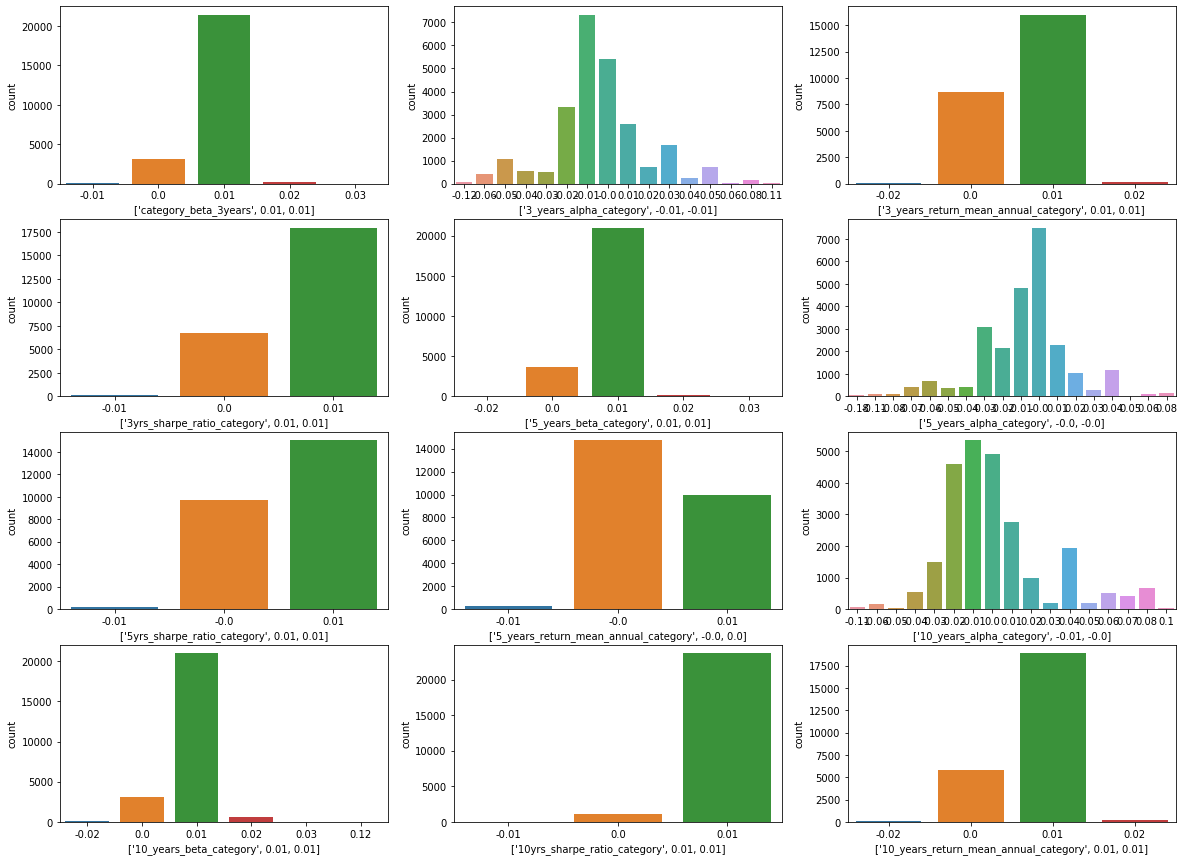

In [296]:
fig, ax = plt.subplots(4,3,figsize=(20, 15))
for col,subplot in zip(['category_beta_3years','3_years_alpha_category','3_years_return_mean_annual_category','3yrs_sharpe_ratio_category','5_years_beta_category','5_years_alpha_category','5yrs_sharpe_ratio_category','5_years_return_mean_annual_category','10_years_alpha_category','10_years_beta_category','10yrs_sharpe_ratio_category','10_years_return_mean_annual_category'],ax.flatten()):
        sns.countplot(col, data=data, ax=subplot)
        subplot.set_xlabel([col,data[col].mode()[0],data[col].median()])
plt.show()

In [297]:
#check the null values in categorical values
data[['greatstone_rating', 'fund_id', 'investment_class', 'inception_date', 'fund_size', 'category', 'parent_company', 'fund_name']].isna().sum()

greatstone_rating    5000
fund_id                 0
investment_class     1480
inception_date          0
fund_size            1480
category                0
parent_company          0
fund_name               0
dtype: int64

In [298]:
print(data.portfolio_cyclical_consumer_allocation.median())
data.groupby('greatstone_rating').median()['portfolio_cyclical_consumer_allocation']

10.46


greatstone_rating
0.0    10.115
1.0     7.260
2.0    10.310
3.0    10.620
4.0    10.710
5.0    11.055
Name: portfolio_cyclical_consumer_allocation, dtype: float64

In [299]:
#Replace missing values in 'investment_class' and 'fund_size' with mode of columns
data['investment_class'].fillna(data['investment_class'].mode()[0], inplace=True)
data['fund_size'].fillna(data['fund_size'].mode()[0], inplace=True)

In [300]:
#check the null values in categorical values
data[['greatstone_rating', 'fund_id', 'investment_class', 'inception_date', 'fund_size', 'category', 'parent_company', 'fund_name']].isna().sum()

greatstone_rating    5000
fund_id                 0
investment_class        0
inception_date          0
fund_size               0
category                0
parent_company          0
fund_name               0
dtype: int64

In [301]:
data['inception_year'] = data['inception_date'].str.split('-').str[0]
data['inception_year'] = data['inception_year'].astype(float)

In [302]:
#Convert inception date to number of years.
#The time in no of years since inception date may be a feature of importance 
from datetime import date
#Today's date
today = date.today()
#print(today)
data['yrs_since_inception'] = np.floor((pd.to_datetime(today)-pd.to_datetime(data['inception_date'])).dt.days/365.25)

In [303]:
#check dtype of yrs _since_inception
print(data['yrs_since_inception'].dtype, data['inception_year'] .dtype)

float64 float64


## Manual encoding of Categorical Variables

In [304]:
print("Number of unique companies",len(data.parent_company.unique()))
print("Number of unique fund names",len(data.fund_name.unique()))
print("Number of unique inception years",len(data.inception_year.unique()))

Number of unique companies 761
Number of unique fund names 24958
Number of unique inception years 88


In [305]:
#Can we weight a company's importance based on the yrs_since_inception
#ax=sns.countplot(data['yrs_since_inception'])
print(data.loc[(data['yrs_since_inception'] >=1) & (data['yrs_since_inception'] <10), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=10) & (data['yrs_since_inception'] <20), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=20) & (data['yrs_since_inception'] <30), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=30) & (data['yrs_since_inception'] <40), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=40) & (data['yrs_since_inception'] <50), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=50) & (data['yrs_since_inception'] <60), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=60) & (data['yrs_since_inception'] <70), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=70) & (data['yrs_since_inception'] <80), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=80) & (data['yrs_since_inception'] <90), 'yrs_since_inception'].count())
print(data.loc[(data['yrs_since_inception'] >=90) & (data['yrs_since_inception'] <100), 'yrs_since_inception'].count())

11693
8612
3810
657
122
42
19
19
19
7


In [306]:
#create new column 'fund_name_pri' which encodes fund_name based on yrs_since_inception
for rownum, row in enumerate(data.fund_name):
  if (data.loc[rownum,'yrs_since_inception'] >=1) & (data.loc[rownum, 'yrs_since_inception'] <10):
    data.loc[rownum,'fund_name_pri'] = 0
  elif(data.loc[rownum,'yrs_since_inception'] >=10) & (data.loc[rownum, 'yrs_since_inception'] <20):
    data.loc[rownum,'fund_name_pri'] = 1
  elif(data.loc[rownum,'yrs_since_inception'] >=20) & (data.loc[rownum, 'yrs_since_inception'] <30):
    data.loc[rownum,'fund_name_pri'] = 2
  elif(data.loc[rownum,'yrs_since_inception'] >=30) & (data.loc[rownum, 'yrs_since_inception'] <40):
    data.loc[rownum,'fund_name_pri'] = 3  
  elif(data.loc[rownum,'yrs_since_inception'] >=40) & (data.loc[rownum, 'yrs_since_inception'] <50):
    data.loc[rownum,'fund_name_pri'] = 4 
  elif(data.loc[rownum,'yrs_since_inception'] >=50) & (data.loc[rownum, 'yrs_since_inception'] <60):
    data.loc[rownum,'fund_name_pri'] = 5
  elif(data.loc[rownum,'yrs_since_inception'] >=60) & (data.loc[rownum, 'yrs_since_inception'] <70):
    data.loc[rownum,'fund_name_pri'] = 6
  elif(data.loc[rownum,'yrs_since_inception'] >=70) & (data.loc[rownum, 'yrs_since_inception'] <80):
    data.loc[rownum,'fund_name_pri'] = 7
  elif(data.loc[rownum,'yrs_since_inception'] >=80) & (data.loc[rownum, 'yrs_since_inception'] <90):
    data.loc[rownum,'fund_name_pri'] = 8
  elif(data.loc[rownum,'yrs_since_inception'] >=90) & (data.loc[rownum, 'yrs_since_inception'] <100):
    data.loc[rownum,'fund_name_pri'] = 9

In [307]:
data.fund_name_pri.value_counts()

0.0    11693
1.0     8612
2.0     3810
3.0      657
4.0      122
5.0       42
7.0       19
8.0       19
6.0       19
9.0        7
Name: fund_name_pri, dtype: int64

In [308]:
#value counts of investment_class column to be encoded
print(data['investment_class'].value_counts())

Blend     11778
Growth     6671
Value      6551
Name: investment_class, dtype: int64


In [309]:
#value counts of fund_size column to be encoded
print(data['fund_size'].value_counts())

Large     15653
Medium     6009
Small      3338
Name: fund_size, dtype: int64


In [310]:
#Number of unique categories to be encoded
print("Number of unique categories",len(data.category.unique()))
data.category.unique()

Number of unique categories 111


array(['Energy Limited Partnership', 'Large Growth', 'Large Value',
       'Target-Date 2035', 'Convertibles', 'Multialternative',
       'Foreign Large Value', 'Allocation - 15% to 30% Equity',
       'Long-Short Credit', 'Large Blend', 'Muni National Long',
       'Emerging Markets Bond', 'Muni Pennsylvania', 'Target-Date 2055',
       'Small Growth', 'Muni New York Intermediate', 'Corporate Bond',
       'Short-Term Bond', 'Foreign Large Blend', 'High Yield Bond',
       'Target-Date 2050', 'Muni National Short',
       'Allocation - 50% to 70% Equity', 'Market Neutral',
       'Long-Term Bond', 'Intermediate-Term Bond', 'World Allocation',
       'Mid-Cap Growth', 'Muni Minnesota', 'Allocation - 85%+ Equity',
       'Target-Date 2030', 'Target-Date Retirement', 'Multisector Bond',
       'Muni National Interm', 'Target-Date 2025', 'World Large Stock',
       'Foreign Small/Mid Value', 'Allocation - 30% to 50% Equity',
       'Technology', 'Europe Stock', 'Global Real Estate',
     

In [311]:
#Relationship between 'investment_class', 'fund_size' and 'category
data[['investment_class', 'fund_size', 'category']].sample(10)

,investment_class,fund_size,category
1662,Blend,Large,Target-Date 2025
12693,Blend,Large,Large Blend
19551,Growth,Medium,Mid-Cap Blend
8582,Blend,Large,Diversified Emerging Mkts
17660,Value,Large,Large Value
13308,Growth,Large,Target-Date 2060+
1405,Blend,Large,Target-Date 2020
19862,Blend,Large,Allocation - 50% to 70% Equity
11274,Blend,Large,Europe Stock
16424,Blend,Large,Target-Date 2025


In [312]:
# create new column 'category_pri' which encodes category based on investment_class and fund_size
for rownum, row in enumerate(data.category):
  if (data.loc[rownum,'fund_size'] =='Large') & (data.loc[rownum, 'investment_class'] =='Blend'):
    data.loc[rownum,'category_pri'] = 0
  elif(data.loc[rownum,'fund_size'] =='Large') & (data.loc[rownum, 'investment_class'] =='Growth'):
    data.loc[rownum,'category_pri'] = 1
  elif(data.loc[rownum,'fund_size'] =='Large') & (data.loc[rownum, 'investment_class'] =='Value'):
    data.loc[rownum,'category_pri'] = 2
  elif(data.loc[rownum,'fund_size'] =='Medium') & (data.loc[rownum, 'investment_class'] =='Blend'):
    data.loc[rownum,'category_pri'] = 3
  elif(data.loc[rownum,'fund_size'] =='Medium') & (data.loc[rownum, 'investment_class'] =='Growth'):
    data.loc[rownum,'category_pri'] = 5
  elif(data.loc[rownum,'fund_size'] =='Medium') & (data.loc[rownum, 'investment_class'] =='Value'):
    data.loc[rownum,'category_pri'] = 4
  elif(data.loc[rownum,'fund_size'] =='Small') & (data.loc[rownum, 'investment_class'] =='Blend'):
    data.loc[rownum,'category_pri'] = 7
  elif(data.loc[rownum,'fund_size'] =='Small') & (data.loc[rownum, 'investment_class'] =='Growth'):
    data.loc[rownum,'category_pri'] = 8
  elif(data.loc[rownum,'fund_size'] =='Small') & (data.loc[rownum, 'investment_class'] =='Value'):
    data.loc[rownum,'category_pri'] = 6

In [313]:
data.category_pri.value_counts()

0.0    8331
1.0    4135
2.0    3187
3.0    2449
4.0    1867
5.0    1693
6.0    1497
7.0     998
8.0     843
Name: category_pri, dtype: int64

## Label Encoding of Cateorical Variables

In [314]:
#label encoding of categorical variables
le = LabelEncoder()
data['investment_class'] = le.fit_transform(data['investment_class'])
le1 = LabelEncoder()
data['fund_size'] = le1.fit_transform(data['fund_size'])

In [315]:
le.classes_, le1.classes_

(array(['Blend', 'Growth', 'Value'], dtype=object),
 array(['Large', 'Medium', 'Small'], dtype=object))

In [316]:
data['fund_size'].unique(), data['investment_class'].unique()

(array([0, 1, 2], dtype=int64), array([2, 1, 0], dtype=int64))

## Ordinal Encoding of Categorical Variables

In [317]:
data.loc[:,'parent_company'].values

array(['DWS', 'Janus Henderson', 'Calvert Research and Management', ...,
       'OppenheimerFunds', 'Miller Value Funds', 'DWS'], dtype=object)

In [318]:
#Ordinal encoding of categorical variables
oe = OrdinalEncoder()
data['parent_company'] = oe.fit_transform(data.loc[:,'parent_company'].values.reshape(-1,1))

In [319]:
len(data['parent_company'].unique())

761

In [320]:
#data['inception_year'].value_counts()

In [321]:
#data.groupby('inception_year')['fund_name'].count()

## Imputing Missing Values in numeric columns

In [322]:
#Convert string columns to float
for i in ['ps_ratio', 'mmc', 'pc_ratio', 'pe_ratio', '3yrs_treynor_ratio_fund', '5yrs_treynor_ratio_fund','10yrs_treynor_ratio_fund']:
    data[i] = data.loc[:,i].str.replace(',', '').astype(float)
#fund_id, investment_class, inception_date, fund_size, category, parent_company, fund_name

In [323]:
#check the columns after conversion
#data.loc[3470:3478,'ps_ratio']

In [324]:
#columns which are numeric
data.select_dtypes(include='number').dtypes

bb_rating                                 float64
below_b_rating                            float64
others_rating                             float64
maturity_bond                             float64
b_rating                                  float64
tag                                         int64
a_rating                                  float64
aaa_rating                                float64
aa_rating                                 float64
bbb_rating                                float64
duration_bond                             float64
portfolio_communication_allocation        float64
portfolio_financial_services              float64
portfolio_industrials_allocation          float64
portfolio_tech_allocation                 float64
portfolio_materials_basic_allocation      float64
portfolio_energy_allocation               float64
portfolio_consumer_defence_allocation     float64
portfolio_healthcare_allocation           float64
portfolio_property_allocation             float64


In [325]:
#Check for Missing or null values in the columns
data.isna().sum()

bb_rating                                   114
below_b_rating                              114
others_rating                               114
maturity_bond                             16907
b_rating                                    114
tag                                           0
a_rating                                    114
aaa_rating                                  114
aa_rating                                   114
bbb_rating                                  114
duration_bond                             15126
portfolio_communication_allocation          114
portfolio_financial_services                114
portfolio_industrials_allocation            114
portfolio_tech_allocation                   114
portfolio_materials_basic_allocation        114
portfolio_energy_allocation                 114
portfolio_consumer_defence_allocation       114
portfolio_healthcare_allocation             114
portfolio_property_allocation               114
portfolio_utils_allocation              

In [326]:
#Drop columns having very high no of missing values
data = data.drop(['maturity_bond', 'duration_bond'], axis=1)
data = data.drop(['2010_return_category','2011_return_category','2010_return_fund','2011_return_fund'],axis=1)

In [327]:
#scale mms column by dividing by 10000
#data['mmc_scaled'] = round(data['mmc']/10000,3)

In [328]:
#np.max(data['total_assets']), np.min(data['total_assets'])

In [329]:
#scale total_asssets column by dividing by 10000000
#data['total_assets_scaled'] = round(data['total_assets']/10000000,3)

In [330]:
#Impute missing values in numeric columns using kNN Imputation
#numeric_data = data.drop(['mmc', 'total_assets', 'greatstone_rating', 'fund_id', 'investment_class', 'inception_date', 'fund_size', 'category', 'parent_company', 'fund_name'], axis=1)
#numeric_columns = numeric_data.columns
#print("Number of numeric columns being imputed:", len(numeric_columns))
#imputer = KNNImputer(n_neighbors=10, weights="uniform")
#imputed_values = imputer.fit_transform(numeric_data)

In [331]:
#convert the numeric columns after imputation to a dataframe
#data_imputed = pd.DataFrame(imputed_values, columns=numeric_columns)
#data_imputed.shape

In [332]:
#data_imputed.head()

In [333]:
#data_imputed.isna().sum()

In [334]:
#Imputing null values in numeric columns with Median of the column
numeric_data = data.drop(['greatstone_rating', 'fund_id', 'inception_date', 'category', 'fund_name'], axis=1)
numeric_columns = numeric_data.columns
print(numeric_data.shape, numeric_data['bbb_rating'].dtype )
#print(numeric_data['bbb_rating'].median())
for col in numeric_data.columns:
    if(numeric_data[col].isna().sum() > 0):
        #print(numeric_data[col].mean(), '\t', numeric_data[col].median())
        numeric_data[col] = numeric_data[col].fillna(numeric_data[col].median())
        
        #q1 = numeric_data[col].quantile(0.25)
        #q3 = numeric_data[col].quantile(0.75)
        #iqr = q3 - q1
        #lower_limit = q1 - 1.5*iqr
        #upper_limit = q3 + 1.5*iqr
        #numeric_data[col] = numeric_data[col].fillna(np.random.uniform(lower_limit,upper_limit))
        #print(numeric_data[col])
        numeric_data[col].astype(float)
print(numeric_data.shape, numeric_data['bbb_rating'].dtype)

(25000, 115) float64
(25000, 115) float64


In [335]:
#numeric_data.dtypes

In [443]:
#df = pd.concat([data[['fund_id','greatstone_rating', 'investment_class', 'fund_size']], data_imputed], axis=1)
#df = pd.concat([data[['fund_id','greatstone_rating', 'investment_class', 'fund_size']], numeric_data], axis=1)
portfolios = ['portfolio_communication_allocation','portfolio_financial_services','portfolio_industrials_allocation',
              'portfolio_tech_allocation','portfolio_materials_basic_allocation','portfolio_energy_allocation','portfolio_consumer_defence_allocation','portfolio_healthcare_allocation',
              'portfolio_property_allocation','portfolio_utils_allocation','portfolio_cyclical_consumer_allocation','portfolio_convertable','portfolio_others','portfolio_preferred']
#drop_cols = ['2012_return_category','2013_category_return','2012_fund_return','2013_return_fund','fund_return_3years','3_years_return_category','5_years_return_fund','5_years_return_category','10_years_return_fund','10_years_return_category']
#drop_cols = ['2012_return_category','2013_category_return','2012_fund_return','2013_return_fund']

df = pd.concat([data[['fund_id','greatstone_rating']],
                numeric_data.drop(['return_ytd','fund_return_3months', '3_months_return_category','inception_year'],axis=1)], axis=1)
df = df.drop(portfolios, axis=1)
df = df.drop(['parent_company','tag'], axis=1)

In [444]:
print(df.shape)

(25000, 97)


In [ ]:
df.dtypes

In [ ]:
#df.isna().sum()

## EDA and Data Visualization

In [ ]:
#data_imputed.describe()
numeric_data.describe()

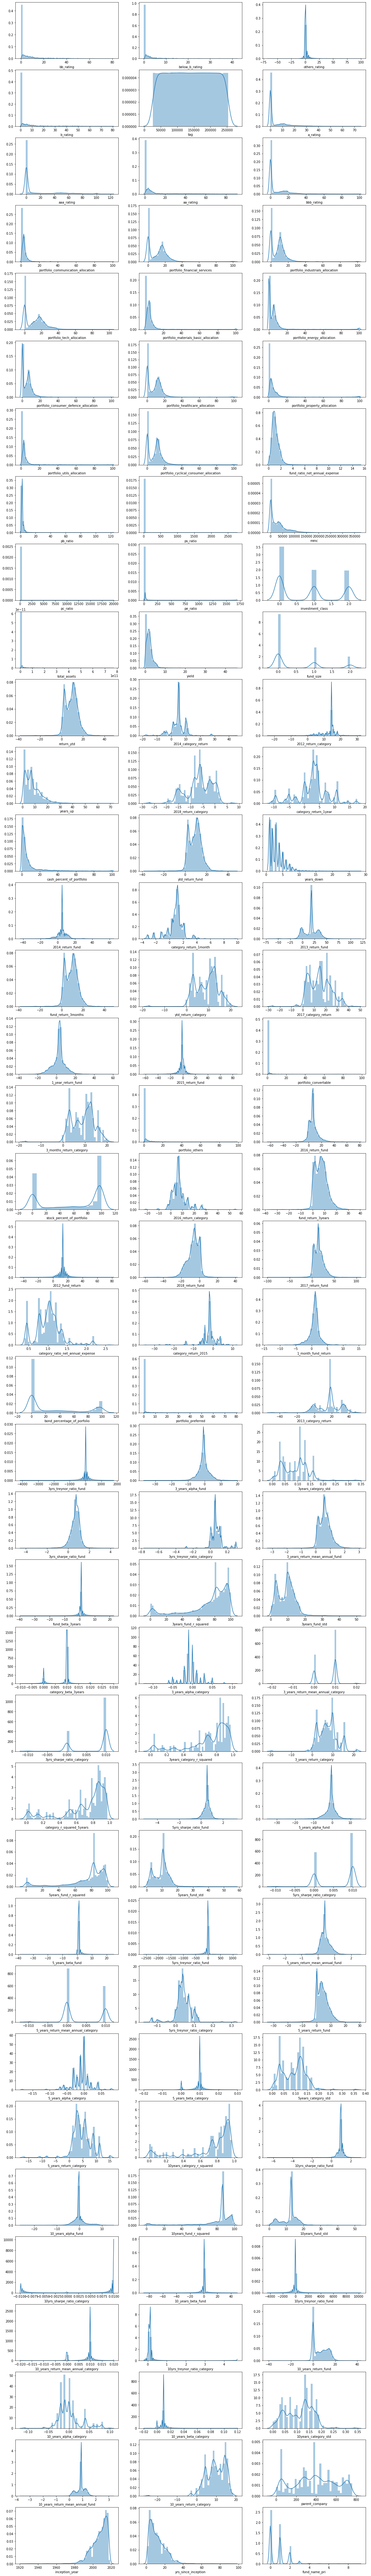

In [341]:
fig, ax = plt.subplots(38,3,figsize=(20, 150))
for col,subplot in zip(numeric_data.columns,ax.flatten()) :
    sns.distplot(numeric_data[col], ax=subplot)
plt.show()

In [342]:
#Function to find outliers
def identify_outliers(col):    
    q1 = numeric_data[col].quantile(0.25)
    q3 = numeric_data[col].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5*iqr
    upper_limit = q3 + 1.5*iqr
    return(col, q1, q3, iqr, lower_limit, upper_limit)

In [343]:
#Detect and impute outliers if required
#outlier_df = pd.DataFrame(columns=['column_name', 'outlier_count'])
#unskewed_list = ['category_beta_3years','3_years_alpha_category','3_years_return_mean_annual_category','3yrs_sharpe_ratio_category','5_years_beta_category','5_years_alpha_category','5yrs_sharpe_ratio_category','5_years_return_mean_annual_category','10_years_alpha_category','10_years_beta_category','10yrs_sharpe_ratio_category','10_years_return_mean_annual_category','tag','investment_class','fund_size','fund_name_pri','category_pri','yrs_since_inception','parent_company','stock_percent_of_portfolio','bond_percentage_of_porfolio','3years_category_r_squared','category_r_squared_5years','10years_category_r_squared']
#median_list = ['category_beta_3years','3_years_alpha_category','5_years_beta_category','5_years_alpha_category','10_years_alpha_category','10_years_beta_category','10yrs_sharpe_ratio_category','10_years_return_mean_annual_category','3years_category_r_squared','category_r_squared_5years','10years_category_r_squared','3_years_return_mean_annual_category']
#no_outlier_list = ['3yrs_sharpe_ratio_category','5yrs_sharpe_ratio_category','5_years_return_mean_annual_category','tag','investment_class','fund_size','fund_name_pri','category_pri','yrs_since_inception','parent_company','stock_percent_of_portfolio','bond_percentage_of_porfolio']
for col in numeric_data.columns :
    col, q1, q3, iqr, lower_limit, upper_limit = identify_outliers(col)
    print("\nColumn name : {}\n Q1 = {} \n Q3 = {}\n IQR = {}".format(col, q1, q3, iqr))
    print(" Lower limit = {}\n Upper limit = {}\n".format(lower_limit, upper_limit))
    outlier_count = len(numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit)])
    if outlier_count != 0 :
        print(outlier_count, "OUTLIERS ARE PRESENT in {} column.".format(col))
        #print("Outlier datapoints in {} column are:".format(col))
        #print(np.array(numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit)][col]))     
        #print(zscore(np.array(numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit)][col])))
        #print("Replacing Outliers with random value between lower and upper limits of the column {}...".format(col))
        #numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col] = numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col].apply(lambda x : np.random.uniform(lower_limit,upper_limit))
        #print('...Outliers are replaced with random number between lower limit and upper limit')
        #if col in median_list:
            #print("Replacing Outliers with mean/median of the column {}...".format(col))
            #numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col] = np.nan
            #numeric_data[col].fillna(round(numeric_data[col].median()), inplace=True)    
            #print('...Outliers are replaced with mean/median')
        #else:
            #print("Replacing Outliers with random value between lower and upper limits of the column {}...".format(col))
            #numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col] = numeric_data.loc[(numeric_data[col] < lower_limit) | (numeric_data[col] > upper_limit), col].apply(lambda x : np.random.uniform(lower_limit,upper_limit))
            #print('...Outliers are replaced with random number between lower limit and upper limit')
    else:
        print("OUTLIERS ARE NOT PRESENT in {} column\n".format(col))


Column name : bb_rating
 Q1 = 0.0 
 Q3 = 2.42
 IQR = 2.42
 Lower limit = -3.63
 Upper limit = 6.05

4166 OUTLIERS ARE PRESENT in bb_rating column.

Column name : below_b_rating
 Q1 = 0.0 
 Q3 = 0.1
 IQR = 0.1
 Lower limit = -0.15000000000000002
 Upper limit = 0.25

5705 OUTLIERS ARE PRESENT in below_b_rating column.

Column name : others_rating
 Q1 = 0.0 
 Q3 = 0.32
 IQR = 0.32
 Lower limit = -0.48
 Upper limit = 0.8

5766 OUTLIERS ARE PRESENT in others_rating column.

Column name : b_rating
 Q1 = 0.0 
 Q3 = 0.7
 IQR = 0.7
 Lower limit = -1.0499999999999998
 Upper limit = 1.7499999999999998

5406 OUTLIERS ARE PRESENT in b_rating column.

Column name : tag
 Q1 = 83021.75 
 Q3 = 196759.25
 IQR = 113737.5
 Lower limit = -87584.5
 Upper limit = 367365.5

OUTLIERS ARE NOT PRESENT in tag column


Column name : a_rating
 Q1 = 0.0 
 Q3 = 8.2775
 IQR = 8.2775
 Lower limit = -12.41625
 Upper limit = 20.69375

1908 OUTLIERS ARE PRESENT in a_rating column.

Column name : aaa_rating
 Q1 = 0.0 
 Q3

442 OUTLIERS ARE PRESENT in 2017_return_fund column.

Column name : category_ratio_net_annual_expense
 Q1 = 0.81 
 Q3 = 1.18
 IQR = 0.3699999999999999
 Lower limit = 0.2550000000000002
 Upper limit = 1.7349999999999999

858 OUTLIERS ARE PRESENT in category_ratio_net_annual_expense column.

Column name : category_return_2015
 Q1 = -2.58 
 Q3 = -0.95
 IQR = 1.6300000000000001
 Lower limit = -5.025
 Upper limit = 1.4950000000000003

6211 OUTLIERS ARE PRESENT in category_return_2015 column.

Column name : 1_month_fund_return
 Q1 = 0.35 
 Q3 = 1.71
 IQR = 1.3599999999999999
 Lower limit = -1.69
 Upper limit = 3.75

2398 OUTLIERS ARE PRESENT in 1_month_fund_return column.

Column name : bond_percentage_of_porfolio
 Q1 = 0.0 
 Q3 = 63.7
 IQR = 63.7
 Lower limit = -95.55000000000001
 Upper limit = 159.25

OUTLIERS ARE NOT PRESENT in bond_percentage_of_porfolio column


Column name : portfolio_preferred
 Q1 = 0.0 
 Q3 = 0.01
 IQR = 0.01
 Lower limit = -0.015
 Upper limit = 0.025

5294 OUTLIERS 

 IQR = 1.0
 Lower limit = -1.5
 Upper limit = 2.5

885 OUTLIERS ARE PRESENT in fund_name_pri column.

Column name : category_pri
 Q1 = 0.0 
 Q3 = 4.0
 IQR = 4.0
 Lower limit = -6.0
 Upper limit = 10.0

OUTLIERS ARE NOT PRESENT in category_pri column



In [344]:
#fig, ax = plt.subplots(38,3,figsize=(20, 150))
#for col,subplot in zip(numeric_data.columns,ax.flatten()) :
    #sns.distplot(numeric_data[col], ax=subplot)
#plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


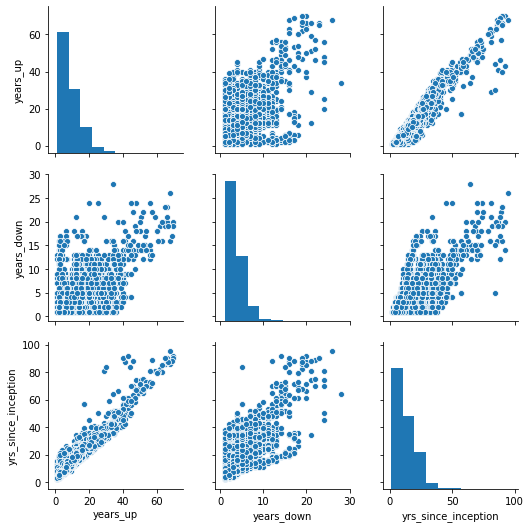

In [345]:
ax = sns.pairplot(data, vars=['years_up', 'years_down', 'yrs_since_inception'], kind='scatter', diag_kind='hist')

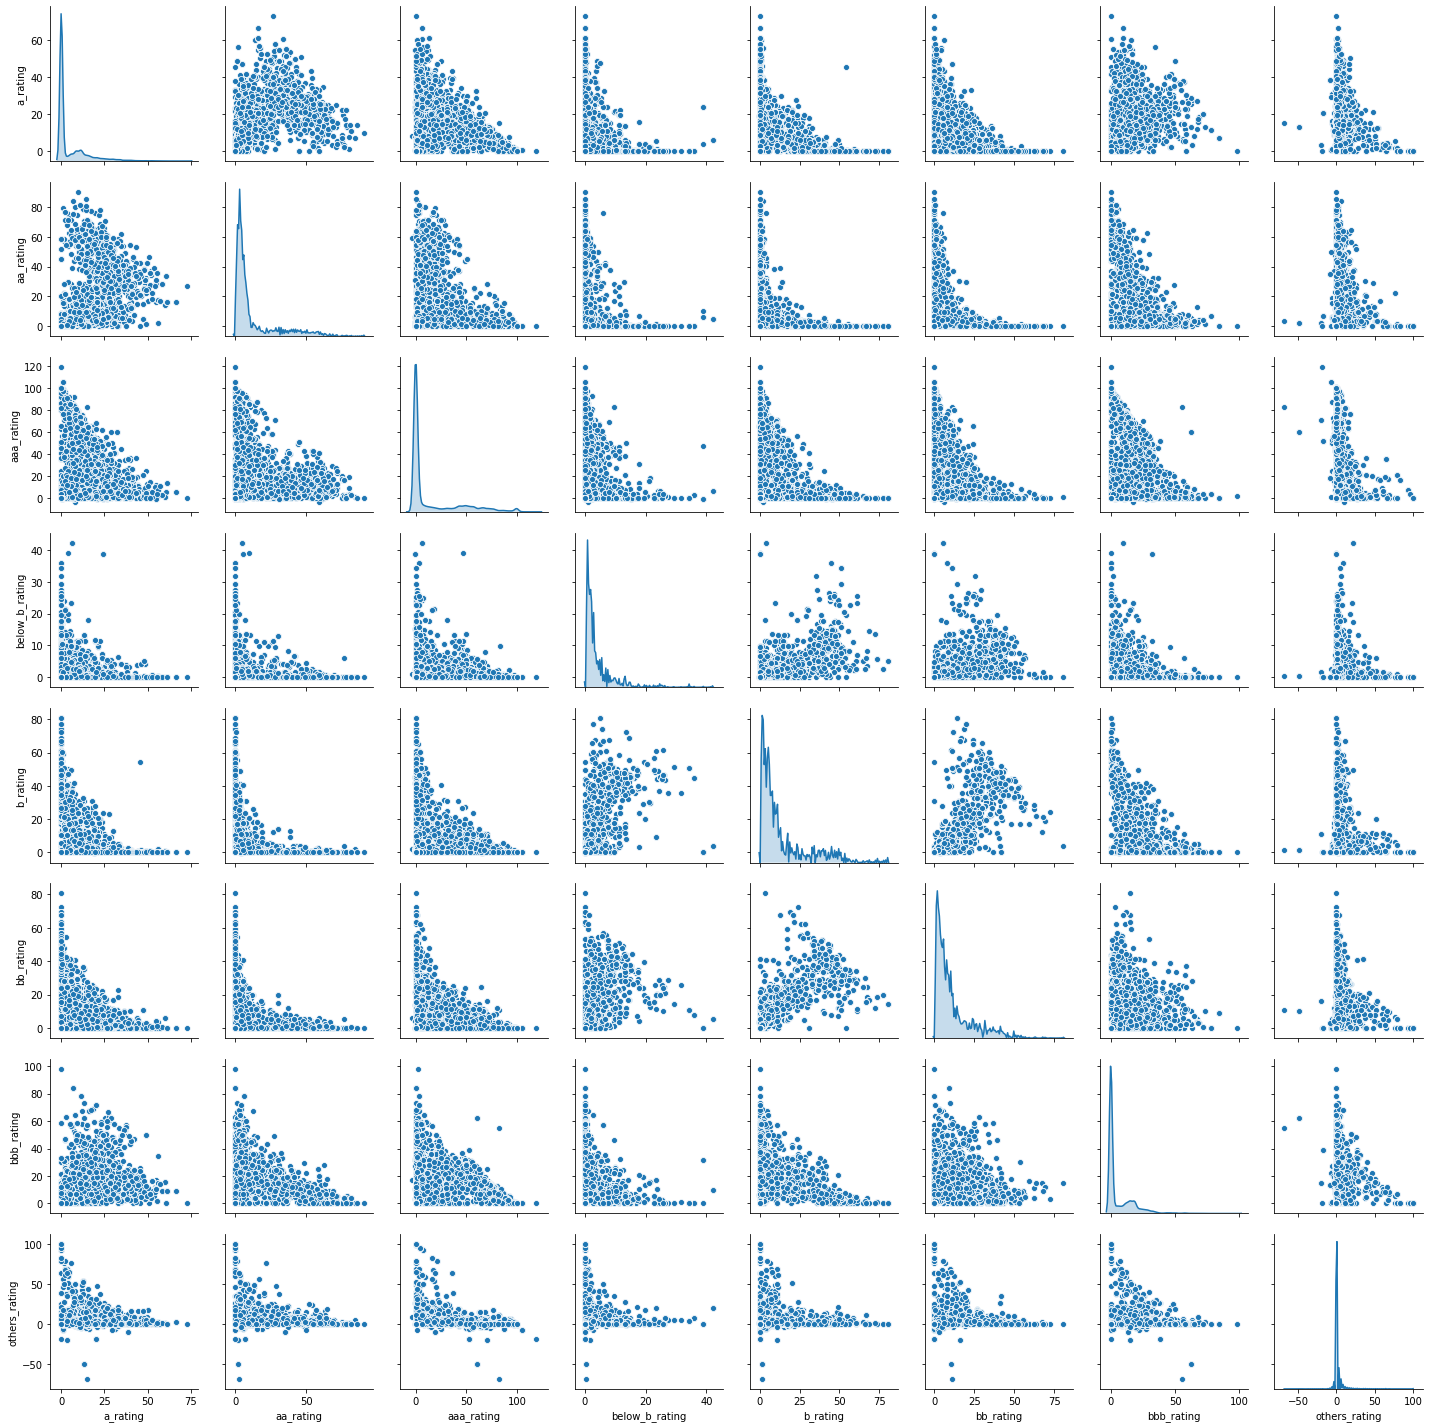

In [346]:
ax = sns.pairplot(df, vars=['a_rating','aa_rating','aaa_rating','below_b_rating','b_rating','bb_rating','bbb_rating','others_rating'],
                  kind='scatter', diag_kind='kde')

3.0    6786
4.0    4614
2.0    4230
5.0    1629
1.0    1376
0.0    1365
Name: greatstone_rating, dtype: int64


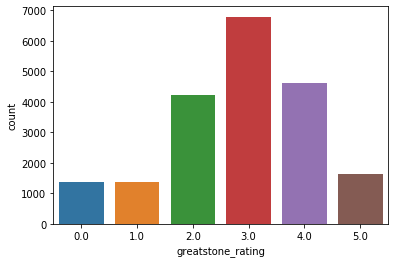

In [347]:
print(df.greatstone_rating.value_counts())
ax = sns.countplot('greatstone_rating', data=df)

0    11778
1     6671
2     6551
Name: investment_class, dtype: int64


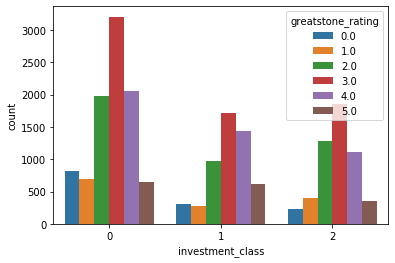

In [348]:
print(df.investment_class.value_counts())
ax = sns.countplot('investment_class',hue='greatstone_rating', data=df)

3


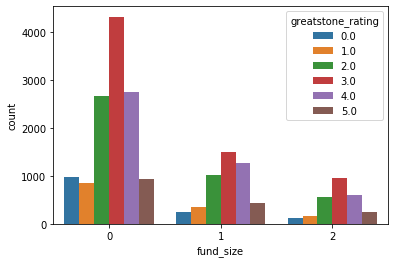

In [349]:
print(len(df.fund_size.unique()))
ax = sns.countplot('fund_size',hue='greatstone_rating', data=df)

In [350]:
plt.figure(figsize=(250,150))
sns.countplot(df.parent_company.value_counts(), data=data)
plt.show()

111


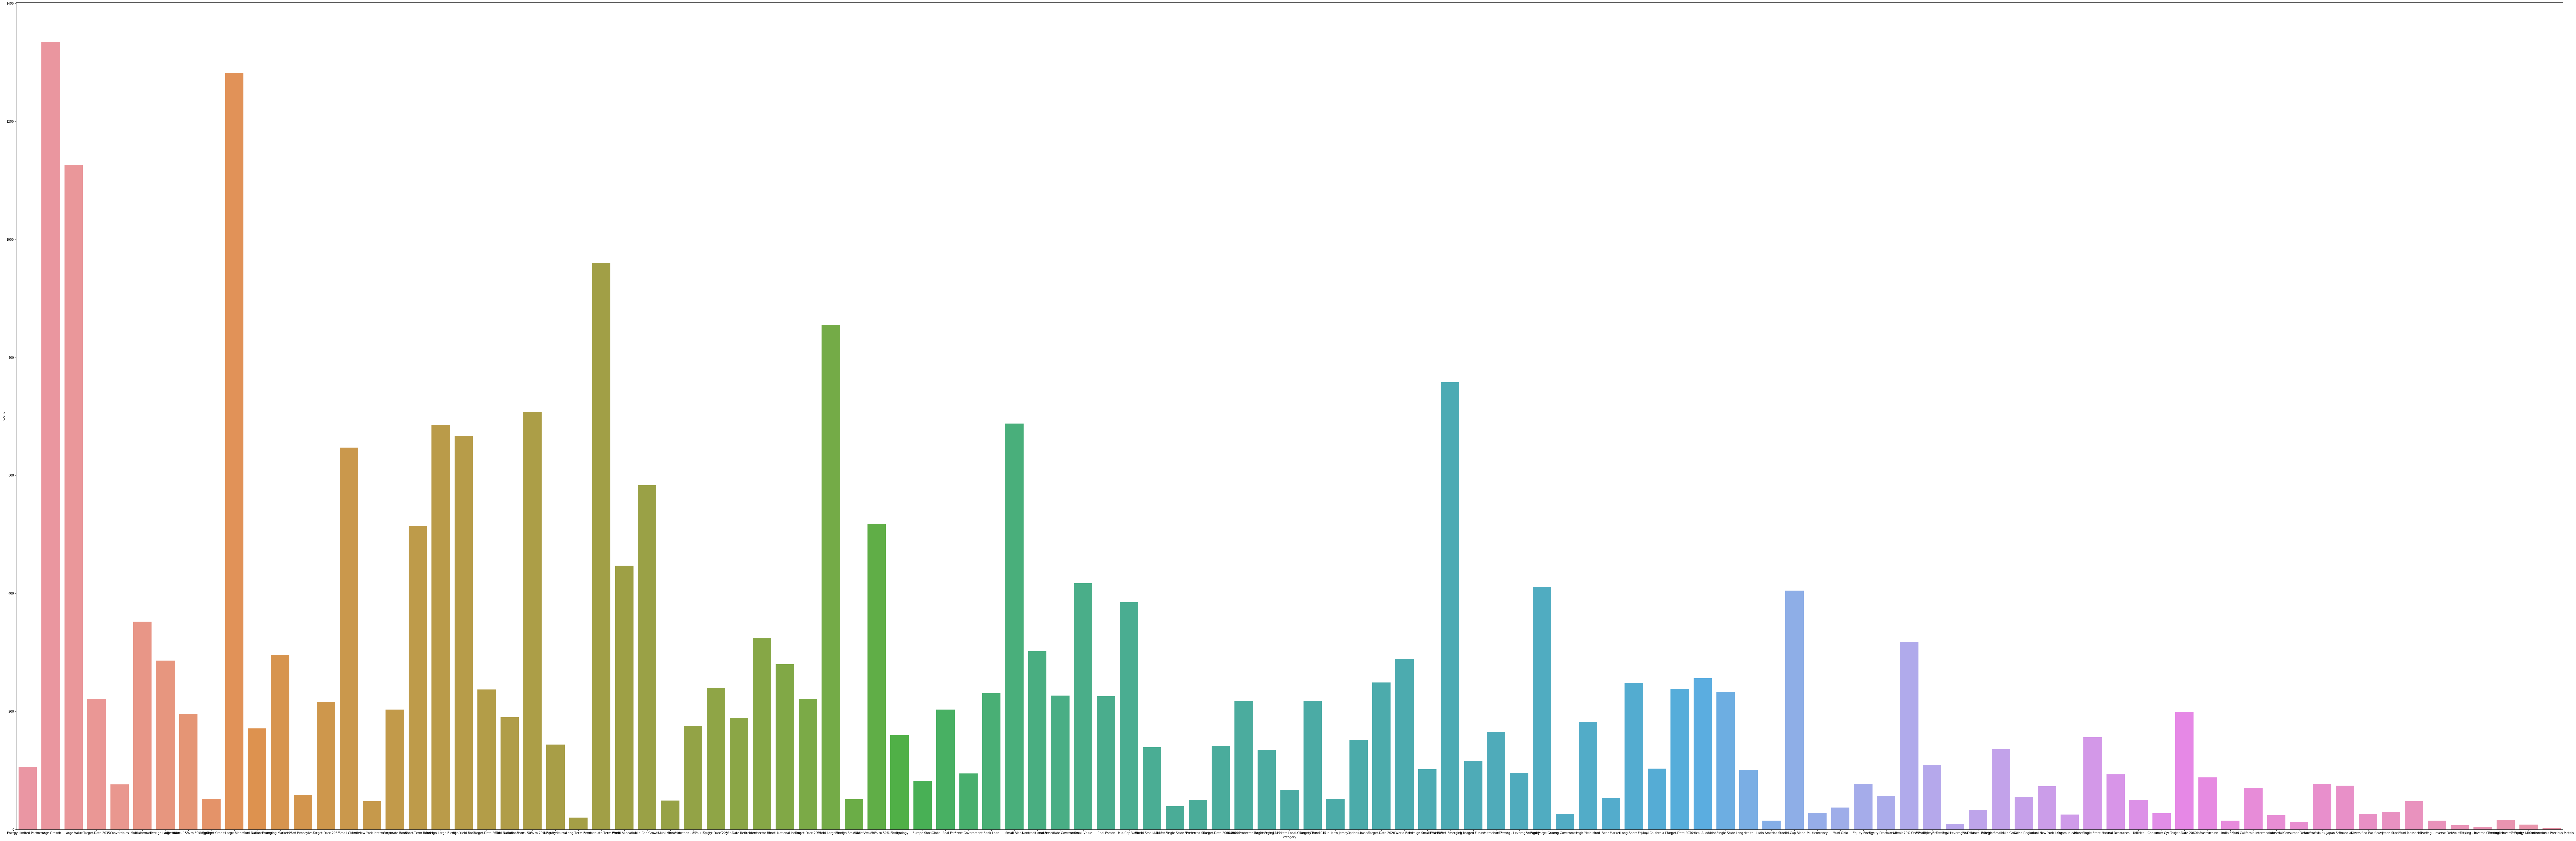

In [351]:
print(len(data.category.unique()))
#print(data.category.unique())
plt.figure(figsize=(150,50))
sns.countplot('category', data=data)
plt.show()

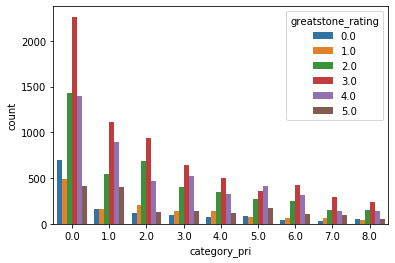

In [352]:
ax=sns.countplot('category_pri', hue='greatstone_rating', data=data)

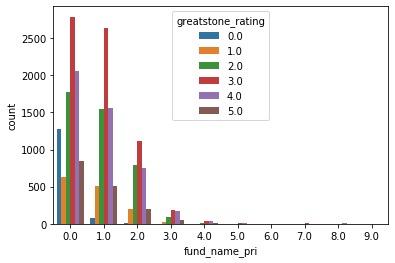

In [353]:
ax=sns.countplot('fund_name_pri',hue='greatstone_rating', data=data)

## Split Dataset into train-set and test-set

In [445]:
train_set = df.loc[df['greatstone_rating'].notnull()]

In [446]:
test_set = df.loc[df['greatstone_rating'].isnull()]
test_set = test_set.drop('greatstone_rating', axis=1)

In [447]:
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [449]:
train_set.greatstone_rating = train_set.greatstone_rating.astype('int')
#train_set.tag = train_set.tag.astype('int')
train_set.greatstone_rating.unique()

array([3, 4, 0, 5, 2, 1], dtype=int64)

In [450]:
train_set.shape, test_set.shape

((20000, 97), (5000, 96))

In [451]:
X = train_set.drop(['fund_id','greatstone_rating'],axis=1)
y = train_set['greatstone_rating']

In [452]:
X.shape, y.shape

((20000, 95), (20000,))

## LDA

In [361]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

In [362]:
#variance explained by each component.
lda.explained_variance_ratio_

array([8.40351867e-01, 1.49438886e-01, 6.94972767e-03, 2.48718968e-03,
       7.72329043e-04])

In [363]:
len(lda.coef_), len(lda.coef_[0])

(6, 97)

In [364]:
lda.classes_

array([0, 1, 2, 3, 4, 5])

In [365]:
lda.get_params()

{'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

In [366]:
X_lda.shape

(20000, 5)

In [367]:
lda.score(X,y)

0.61265

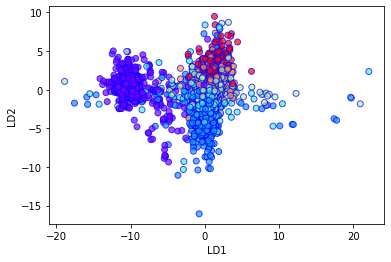

In [368]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

## PCA

In [369]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X,y)

In [370]:
pca.explained_variance_ratio_

array([1.00000000e+00, 1.19886744e-11])

In [371]:
len(pca.components_), len(pca.components_[0] )

(2, 97)

In [372]:
pca.explained_variance_

array([3.60534459e+20, 4.32233024e+09])

In [373]:
pca.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 2,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [374]:
X_pca.shape

(20000, 2)

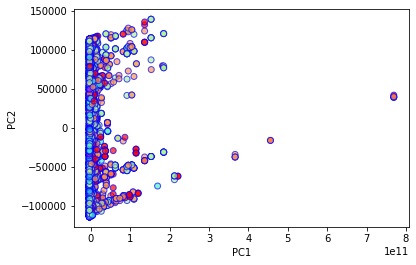

In [375]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

## Model Building

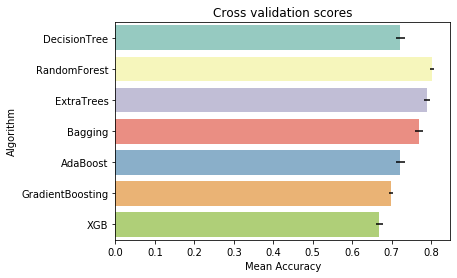

In [453]:
# Modeling step Test differents algorithms
random_state = 123
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate=0.1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(xgb.XGBClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y, scoring = "accuracy", cv = kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree", "RandomForest",
                                                                                     "ExtraTrees","Bagging","AdaBoost",
                                                                                      "GradientBoosting","XGB"]})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


In [456]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.72255,0.011179,DecisionTree
1,0.80225,0.006076,RandomForest
2,0.79040,0.008182,ExtraTrees
3,0.77035,0.010502,Bagging
4,0.72210,0.011458,AdaBoost
5,0.69855,0.006311,GradientBoosting
6,0.66840,0.008634,XGB


In [457]:
#Split features and labels into Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
#X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.1)

In [458]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((18000, 95), (18000,), (2000, 95), (2000,))

In [459]:
#Scale X_train and X_test using zscore
X_trainZ = zscore(X_train)
X_testZ = zscore(X_test)

In [460]:
sscaler = StandardScaler()
X_trainS = sscaler.fit_transform(X_train)
X_testS = sscaler.transform(X_test)

In [461]:
normalizer = Normalizer()
X_trainN = normalizer.fit_transform(X_train)
X_testN = normalizer.transform(X_test)

In [462]:
import time
dict_clf = {}

In [384]:
#KNN Classifier
KNN = KNeighborsClassifier(n_neighbors=5, weights='distance')
KNN.fit(X_trainS, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [385]:
print(KNN.score(X_trainS, y_train))
print(KNN.score(X_testS, y_test))

1.0
0.6504


In [386]:
#LogisticRegression Classifier
lr_model = LogisticRegression(solver='saga',max_iter=5000, multi_class='multinomial', random_state=123)
lr_model.fit(X_trainS, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [387]:
print(lr_model.score(X_trainS , y_train))
print(lr_model.score(X_testS , y_test))

0.6868
0.6708


In [388]:
#Gaussian Naive Bayes Classifier
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [389]:
print(gnb_model.score(X_train , y_train))
print(gnb_model.score(X_test , y_test))

0.11733333333333333
0.1042


In [390]:
# 1. Decision Tree
paramgrid = {
    'criterion':         ['entropy', 'gini'],
    'max_depth':         [10, 12, 14, 16, 20], 
    'max_features':      [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_samples_leaf':  list(range(1, 7)),
    'min_samples_split':  list(range(2, 8, 2))
}
DT = GridSearchCV(DecisionTreeClassifier(random_state=77),
                  paramgrid,
                  cv=5)
t0 = time.time()
DT.fit(X_train, y_train)
t = time.time() - t0
best_clf = DT.best_estimator_
best_params = DT.best_params_
best_score = DT.best_score_
name = 'DT'
best_clf.fit(X_train, y_train)
acc_eval = accuracy_score(y_test, best_clf.predict(X_test))
dict_clf[name] = {
    'best_par': best_params,
    'best_clf': best_clf,
    'best_score': best_score,
    'score_eval': acc_eval,
    'fit_time': t,
}

In [391]:
dict_clf['DT']

{'best_par': {'criterion': 'entropy',
  'max_depth': 20,
  'max_features': 0.9,
  'min_samples_leaf': 1,
  'min_samples_split': 6},
 'best_clf': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=20, max_features=0.9, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=6,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=77, splitter='best'),
 'best_score': 0.6895333333333333,
 'score_eval': 0.6994,
 'fit_time': 2693.2294001579285}

In [394]:
# DecisionTree Classifier
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth=20, 
                                  max_features=0.9, min_samples_leaf=1, 
                                  min_samples_split=6,  random_state=123)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=0.9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [395]:
print(dt_model.score(X_train , y_train))
print(dt_model.score(X_test , y_test))

0.9697333333333333
0.7022


In [396]:
#predicted values
y_pred_dt = dt_model.predict(X_test)
print(precision_score(y_test, y_pred_dt, average='weighted'))
print(classification_report(y_test,y_pred_dt ))

0.7029202215466956
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       323
           1       0.62      0.67      0.64       325
           2       0.67      0.67      0.67      1055
           3       0.72      0.70      0.71      1741
           4       0.68      0.67      0.67      1158
           5       0.66      0.69      0.67       398

    accuracy                           0.70      5000
   macro avg       0.72      0.73      0.72      5000
weighted avg       0.70      0.70      0.70      5000



In [397]:
# 2. Random Forest
paramgrid = {
    'n_estimators':      [10],
    'max_depth':         [10, 12, 14, 16], 
    'max_samples':   [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features':  [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_samples_leaf':  list(range(1, 5)),
    'min_samples_split':  list(range(2, 6, 2)),
    #'bootstrap':          [True,False]
}
RF = GridSearchCV(RandomForestClassifier(random_state=77),
                  paramgrid,
                  cv=5)
t0 = time.time()
RF.fit(X_train, y_train)
t = time.time() - t0
best_clf = RF.best_estimator_
best_params = RF.best_params_
best_score = RF.best_score_
name = 'RF'
best_clf.fit(X_train, y_train)
acc_eval = accuracy_score(y_test, best_clf.predict(X_test))
dict_clf[name] = {
    'best_par': best_params,
    'best_clf': best_clf,
    'best_score': best_score,
    'score_eval': acc_eval,
    'fit_time': t,
}

In [107]:
dict_clf['RF']

{'best_par': {'max_depth': 16,
  'max_features': 0.7,
  'max_samples': 0.9,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 10},
 'best_clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=16, max_features=0.7,
                        max_leaf_nodes=None, max_samples=0.9,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10,
                        n_jobs=None, oob_score=False, random_state=77, verbose=0,
                        warm_start=False),
 'best_score': 0.7555555555555555,
 'score_eval': 0.761,
 'fit_time': 10458.906872272491}

In [463]:
#RandomForest Classifier
rf_model = RandomForestClassifier(n_estimators=500,criterion='gini', max_depth=16,
                                  min_samples_split=2, min_samples_leaf=1,
                                  max_features=0.7, max_samples=0.9, max_leaf_nodes= None,
                                  bootstdrap=False, oob_score=False, random_state=123)
rf_model.fit(X_train, y_train)
#rf_model.fit(X, y)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features=0.7,
                       max_leaf_nodes=None, max_samples=0.9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [464]:
print(rf_model.score(X_train , y_train))
print(rf_model.score(X_test , y_test))
#print(rf_model.score(X , y))

0.9964444444444445
0.794


In [465]:
#predicted values
y_pred_rf = rf_model.predict(X_test)
#y_pred_rf = rf_model.predict(X)

print(precision_score(y_test, y_pred_rf, average='weighted'))
#print(precision_score(y, y_pred_rf, average='weighted'))

print(classification_report(y_test,y_pred_rf ))
#print(classification_report(y,y_pred_rf ))

0.7946421616952639
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       128
           1       0.79      0.69      0.73       122
           2       0.77      0.78      0.78       432
           3       0.78      0.81      0.80       680
           4       0.77      0.78      0.78       480
           5       0.82      0.72      0.77       158

    accuracy                           0.79      2000
   macro avg       0.82      0.79      0.81      2000
weighted avg       0.79      0.79      0.79      2000



In [565]:
rf_model = RandomForestClassifier(n_estimators=100,criterion='gini', max_depth=16,
                                  min_samples_split=2, min_samples_leaf=3,
                                  max_features=0.5, max_samples=0.5, max_leaf_nodes= None,
                                  bootstrap=False, oob_score=False, random_state=123)
cv_results = cross_val_score(rf_model, X, y, cv=kfold)
print(cv_results)
print("Accuracy: %.3f%% (%.3f%%)" % (cv_results.mean()*100.0, cv_results.std()*100.0))

[0.78   0.8055 0.795  0.803  0.812  0.8065 0.804  0.813  0.793  0.816 ]
Accuracy: 80.280% (1.031%)


In [584]:
rf_model.fit(X,y)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features=0.5,
                       max_leaf_nodes=None, max_samples=0.5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [401]:
# 2. Extra Trees Classifier
paramgrid = {
    'n_estimators':      [10],
    'max_depth':         [10, 12, 14, 16], 
    'max_samples':   [0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features':  [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_samples_leaf':  list(range(1, 5)),
    'min_samples_split':  list(range(2, 6, 2)),
}
ET = GridSearchCV(ExtraTreesClassifier(random_state=77),
                  paramgrid,
                  cv=5)
t0 = time.time()
ET.fit(X_train, y_train)
t = time.time() - t0
best_clf = ET.best_estimator_
best_params = ET.best_params_
best_score = ET.best_score_
name = 'ET'
best_clf.fit(X_train, y_train)
acc_eval = accuracy_score(y_test, best_clf.predict(X_test))
dict_clf[name] = {
    'best_par': best_params,
    'best_clf': best_clf,
    'best_score': best_score,
    'score_eval': acc_eval,
    'fit_time': t,
}

In [402]:
dict_clf['ET']

{'best_par': {'max_depth': 16,
  'max_features': 0.8,
  'max_samples': 0.5,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 10},
 'best_clf': ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=16, max_features=0.8,
                      max_leaf_nodes=None, max_samples=0.5,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                      oob_score=False, random_state=77, verbose=0,
                      warm_start=False),
 'best_score': 0.7658,
 'score_eval': 0.7876,
 'fit_time': 3608.7537677288055}

In [403]:
#ExtraTrees Classifier
et_model = ExtraTreesClassifier(n_estimators=500,criterion='gini', max_depth=16, min_samples_split=2, 
                                min_samples_leaf=1, max_features=0.8, max_samples=0.5,
                                max_leaf_nodes= None, bootstrap=False, oob_score=False, random_state=123)
et_model.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=16, max_features=0.8,
                     max_leaf_nodes=None, max_samples=0.5,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500,
                     n_jobs=None, oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [404]:
print(et_model.score(X_train , y_train))
print(et_model.score(X_test , y_test))

0.9988
0.8132


In [405]:
#predicted values
y_pred_et = et_model.predict(X_test)
print(precision_score(y_test, y_pred_et, average='weighted'))
print(classification_report(y_test,y_pred_et))

0.8149539451729073
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       323
           1       0.87      0.67      0.76       325
           2       0.79      0.80      0.79      1055
           3       0.80      0.85      0.82      1741
           4       0.79      0.78      0.79      1158
           5       0.85      0.75      0.79       398

    accuracy                           0.81      5000
   macro avg       0.85      0.81      0.82      5000
weighted avg       0.81      0.81      0.81      5000



In [406]:
# 2. Bagging Classifier
paramgrid = {
    'n_estimators':  [10],
    'max_samples':   [0.30, 0.40, 0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features':  [0.30, 0.40, 0.5, 0.6, 0.7, 0.8, 0.9]
}
BC = GridSearchCV(BaggingClassifier(random_state=77),
                  paramgrid,
                  cv=5)
t0 = time.time()
BC.fit(X_train, y_train)
t = time.time() - t0
best_clf = BC.best_estimator_
best_params = BC.best_params_
best_score = BC.best_score_
name = 'BC'
best_clf.fit(X_train, y_train)
acc_eval = accuracy_score(y_test, best_clf.predict(X_test))
dict_clf[name] = {
    'best_par': best_params,
    'best_clf': best_clf,
    'best_score': best_score,
    'score_eval': acc_eval,
    'fit_time': t,
}

In [110]:
dict_clf['BC']

{'best_par': {'max_features': 0.3, 'max_samples': 0.9, 'n_estimators': 10},
 'best_clf': BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                   max_features=0.3, max_samples=0.9, n_estimators=10,
                   n_jobs=None, oob_score=False, random_state=77, verbose=0,
                   warm_start=False),
 'best_score': 0.7701666666666668,
 'score_eval': 0.7745,
 'fit_time': 607.3655490875244}

In [466]:
#Bagging Classifier
Bagging_model = BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state=123), n_estimators=500, 
                                  bootstrap=True,bootstrap_features=False,max_features=0.6,
                                  max_samples=0.9,oob_score=False, random_state=123)
                                  
Bagging_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=123,
 

In [467]:
print(Bagging_model.score(X_train , y_train))
print(Bagging_model.score(X_test , y_test))

1.0
0.8005


In [468]:
#predicted values
y_pred_bgg = Bagging_model.predict(X_test)
print(precision_score(y_test, y_pred_bgg, average='weighted'))
print(classification_report(y_test,y_pred_bgg ))

0.8020710424179637
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       128
           1       0.86      0.68      0.76       122
           2       0.77      0.80      0.78       432
           3       0.79      0.82      0.80       680
           4       0.78      0.79      0.78       480
           5       0.83      0.74      0.78       158

    accuracy                           0.80      2000
   macro avg       0.84      0.80      0.82      2000
weighted avg       0.80      0.80      0.80      2000



In [407]:
# 4. XGBoost
paramgrid = {
    'n_estimators':  [100],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth':     [10, 12],
    'gamma':         [0, 0.1],
    'objective':     ['multi:softmax'],
    'eval_metric':   ['merror']
}
GS = GridSearchCV(xgb.XGBClassifier(random_state=77),
                  paramgrid,
                  cv=5)
t0 = time.time()
GS.fit(X_train, y_train)
t = time.time() - t0
best_clf = GS.best_estimator_
best_params = GS.best_params_
best_score = GS.best_score_
name = 'XGB'
best_clf.fit(X_train, y_train)
acc_eval = accuracy_score(y_test, best_clf.predict(X_test))
dict_clf[name] = {
    'best_par': best_params,
    'best_clf': best_clf,
    'best_score': best_score,
    'score_eval': acc_eval,
    'fit_time': t,
}

In [408]:
dict_clf['XGB']

{'best_par': {'eval_metric': 'merror',
  'gamma': 0.1,
  'learning_rate': 0.15,
  'max_depth': 10,
  'n_estimators': 100,
  'objective': 'multi:softmax'},
 'best_clf': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
               gamma=0.1, learning_rate=0.15, max_delta_step=0, max_depth=10,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='multi:softprob', random_state=77,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1),
 'best_score': 0.78,
 'score_eval': 0.8058,
 'fit_time': 8953.619213819504}

In [431]:
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
               gamma=0.1, learning_rate=0.15, max_delta_step=0, max_depth=10,
               min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
               nthread=None, objective='multi:softprob', random_state=77,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1)

xgb_model.fit(X_trainS, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0.1, learning_rate=0.15, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=77,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [432]:
print(xgb_model.score(X_trainS , y_train))
print(xgb_model.score(X_testS , y_test))

1.0
0.8072


In [433]:
#predicted values
y_pred_xgb = xgb_model.predict(X_testS)
print(precision_score(y_test, y_pred_xgb, average='weighted'))
print(classification_report(y_test,y_pred_xgb))

0.8082033278067627
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       323
           1       0.85      0.70      0.77       325
           2       0.78      0.78      0.78      1055
           3       0.80      0.84      0.82      1741
           4       0.79      0.79      0.79      1158
           5       0.82      0.75      0.78       398

    accuracy                           0.81      5000
   macro avg       0.84      0.81      0.82      5000
weighted avg       0.81      0.81      0.81      5000



#### Predict on test_set

In [417]:
X_val  = test_set.drop(['fund_id'], axis=1)
X_val.shape

(5000, 97)

In [418]:
y_val = et_model.predict(X_val)

In [419]:
y_val.shape, np.unique(y_val)

((5000,), array([0, 1, 2, 3, 4, 5]))

### Submission

In [420]:
results = pd.DataFrame()
results['fund_id']=test_set['fund_id']
results['greatstone_rating']=y_val
print(results.shape)

(5000, 2)


In [421]:
results.head()

,fund_id,greatstone_rating
0,264614c6-5ac3-4146-ba26-1674b136cb40,2
1,08702e4f-c5bb-4f0a-b63b-f9e4a0eb2425,3
2,cf56db43-046b-49d0-b8f0-90fe9cf8aacf,3
3,3faa81fc-9640-43d0-8b68-e5b06c65bfe6,3
4,09e24f3d-7191-4207-887c-98f31c6b59d2,3


In [422]:
results.to_csv("results.csv",index=False)